### Currently, this notebook is used for:
    - loading the altSfMix experiment data in python format
    - plotting responses

### Set up

In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import helper_fcns
import autoreload

import sys # so that we can import model_responses (in different folder)
import model_responses

% matplotlib inline 

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_cluster.mplstyle');

# at CNS
# dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/recordings/';
# savePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/';
# personal mac
dataPath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/structures/';
save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/figures/';

conDig = 3; # round contrast to the 3rd digit

which_cell = 4; # index into the dataList

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();

cellStruct = np.load(dataPath + dataList['unitName'][which_cell] + '_sfm.npy', encoding='latin1').item();

In [78]:
autoreload.reload(helper_fcns)

<module 'helper_fcns' from '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/functions/helper_fcns.py'>

In [2]:
data = cellStruct['sfm']['exp']['trial'];

In [56]:
cellStruct = np.load(dataPath + dataList['unitName'][which_cell] + '_sfm.npy', encoding='latin1').item();

In [95]:
zzz

(0.50149724244568572,
 array([  6.23033162e+00,   1.00450127e+01,   6.06606518e+00, ...,
          4.85659897e-04,   1.13819018e+01,   1.09855106e-02]))

### Organize data
#### determine contrasts, center spatial frequency, dispersions

In [79]:
data = cellStruct['sfm']['exp']['trial'];

resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

all_disps = stimVals[0];
all_cons = stimVals[1];
all_sfs = stimVals[2];

nCons = len(all_cons);
nSfs = len(all_sfs);
nDisps = len(all_disps);

#### Unpack responses

In [80]:
respMean = resp[0];
respStd = resp[1];
predMean = resp[2];
predStd = resp[3];

#### Load descriptive model fits

In [81]:
descrFits = np.load(dataPath + 'descrFits.npy', encoding = 'latin1').item();
descrFits = descrFits[which_cell]['params']; # just get this cell

### Plots

#### Plots by dispersion

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


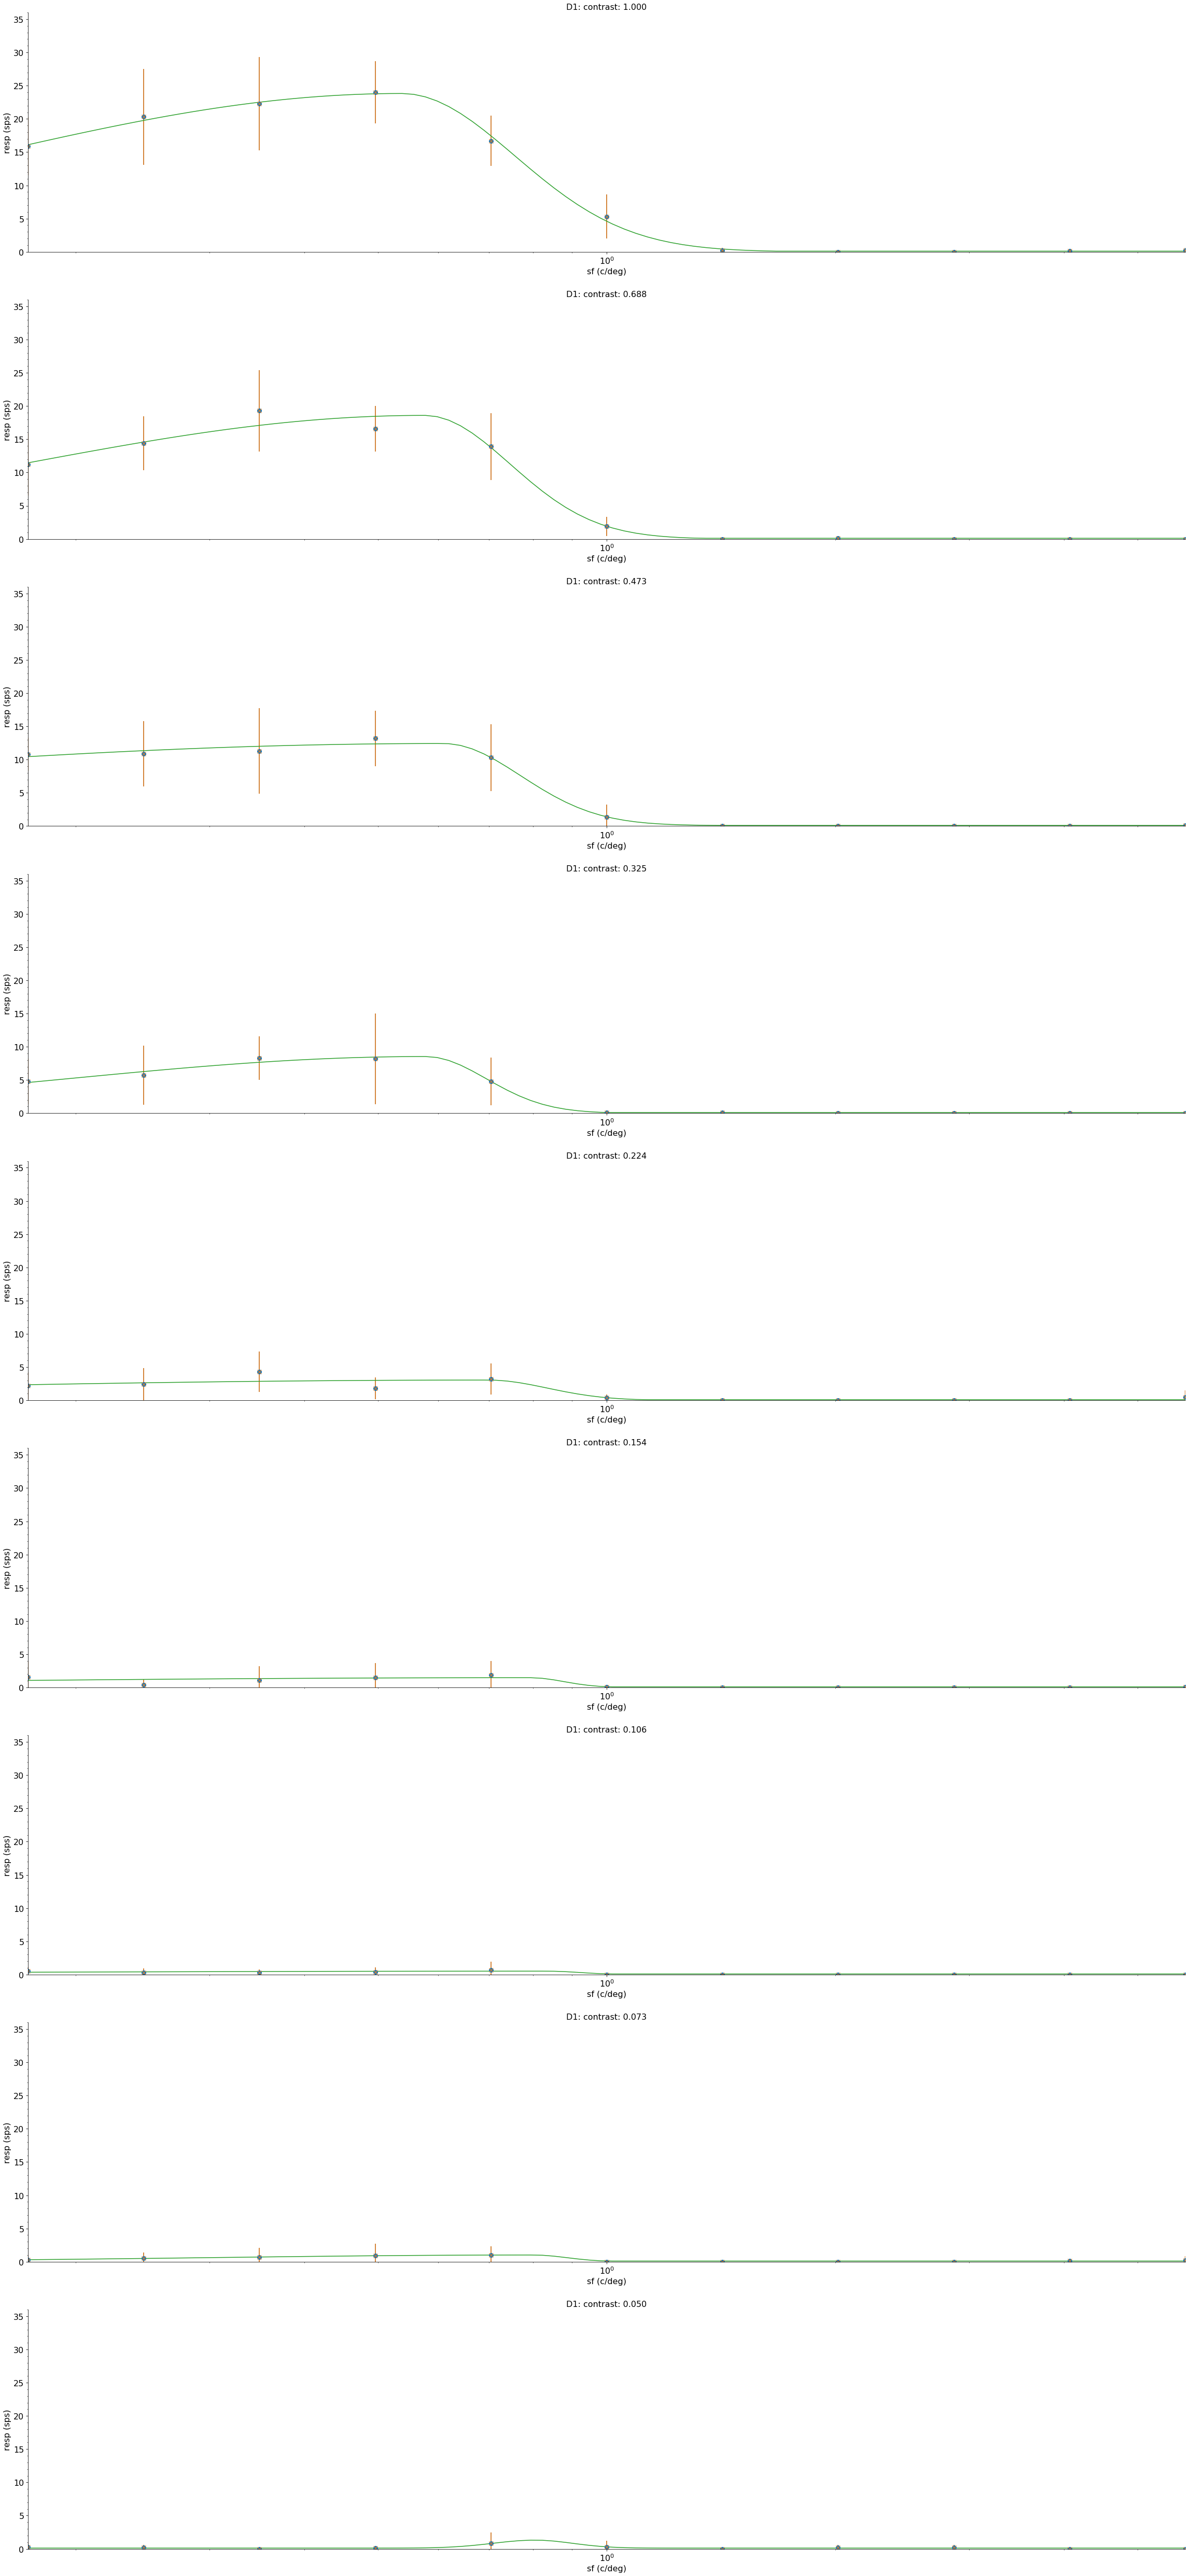

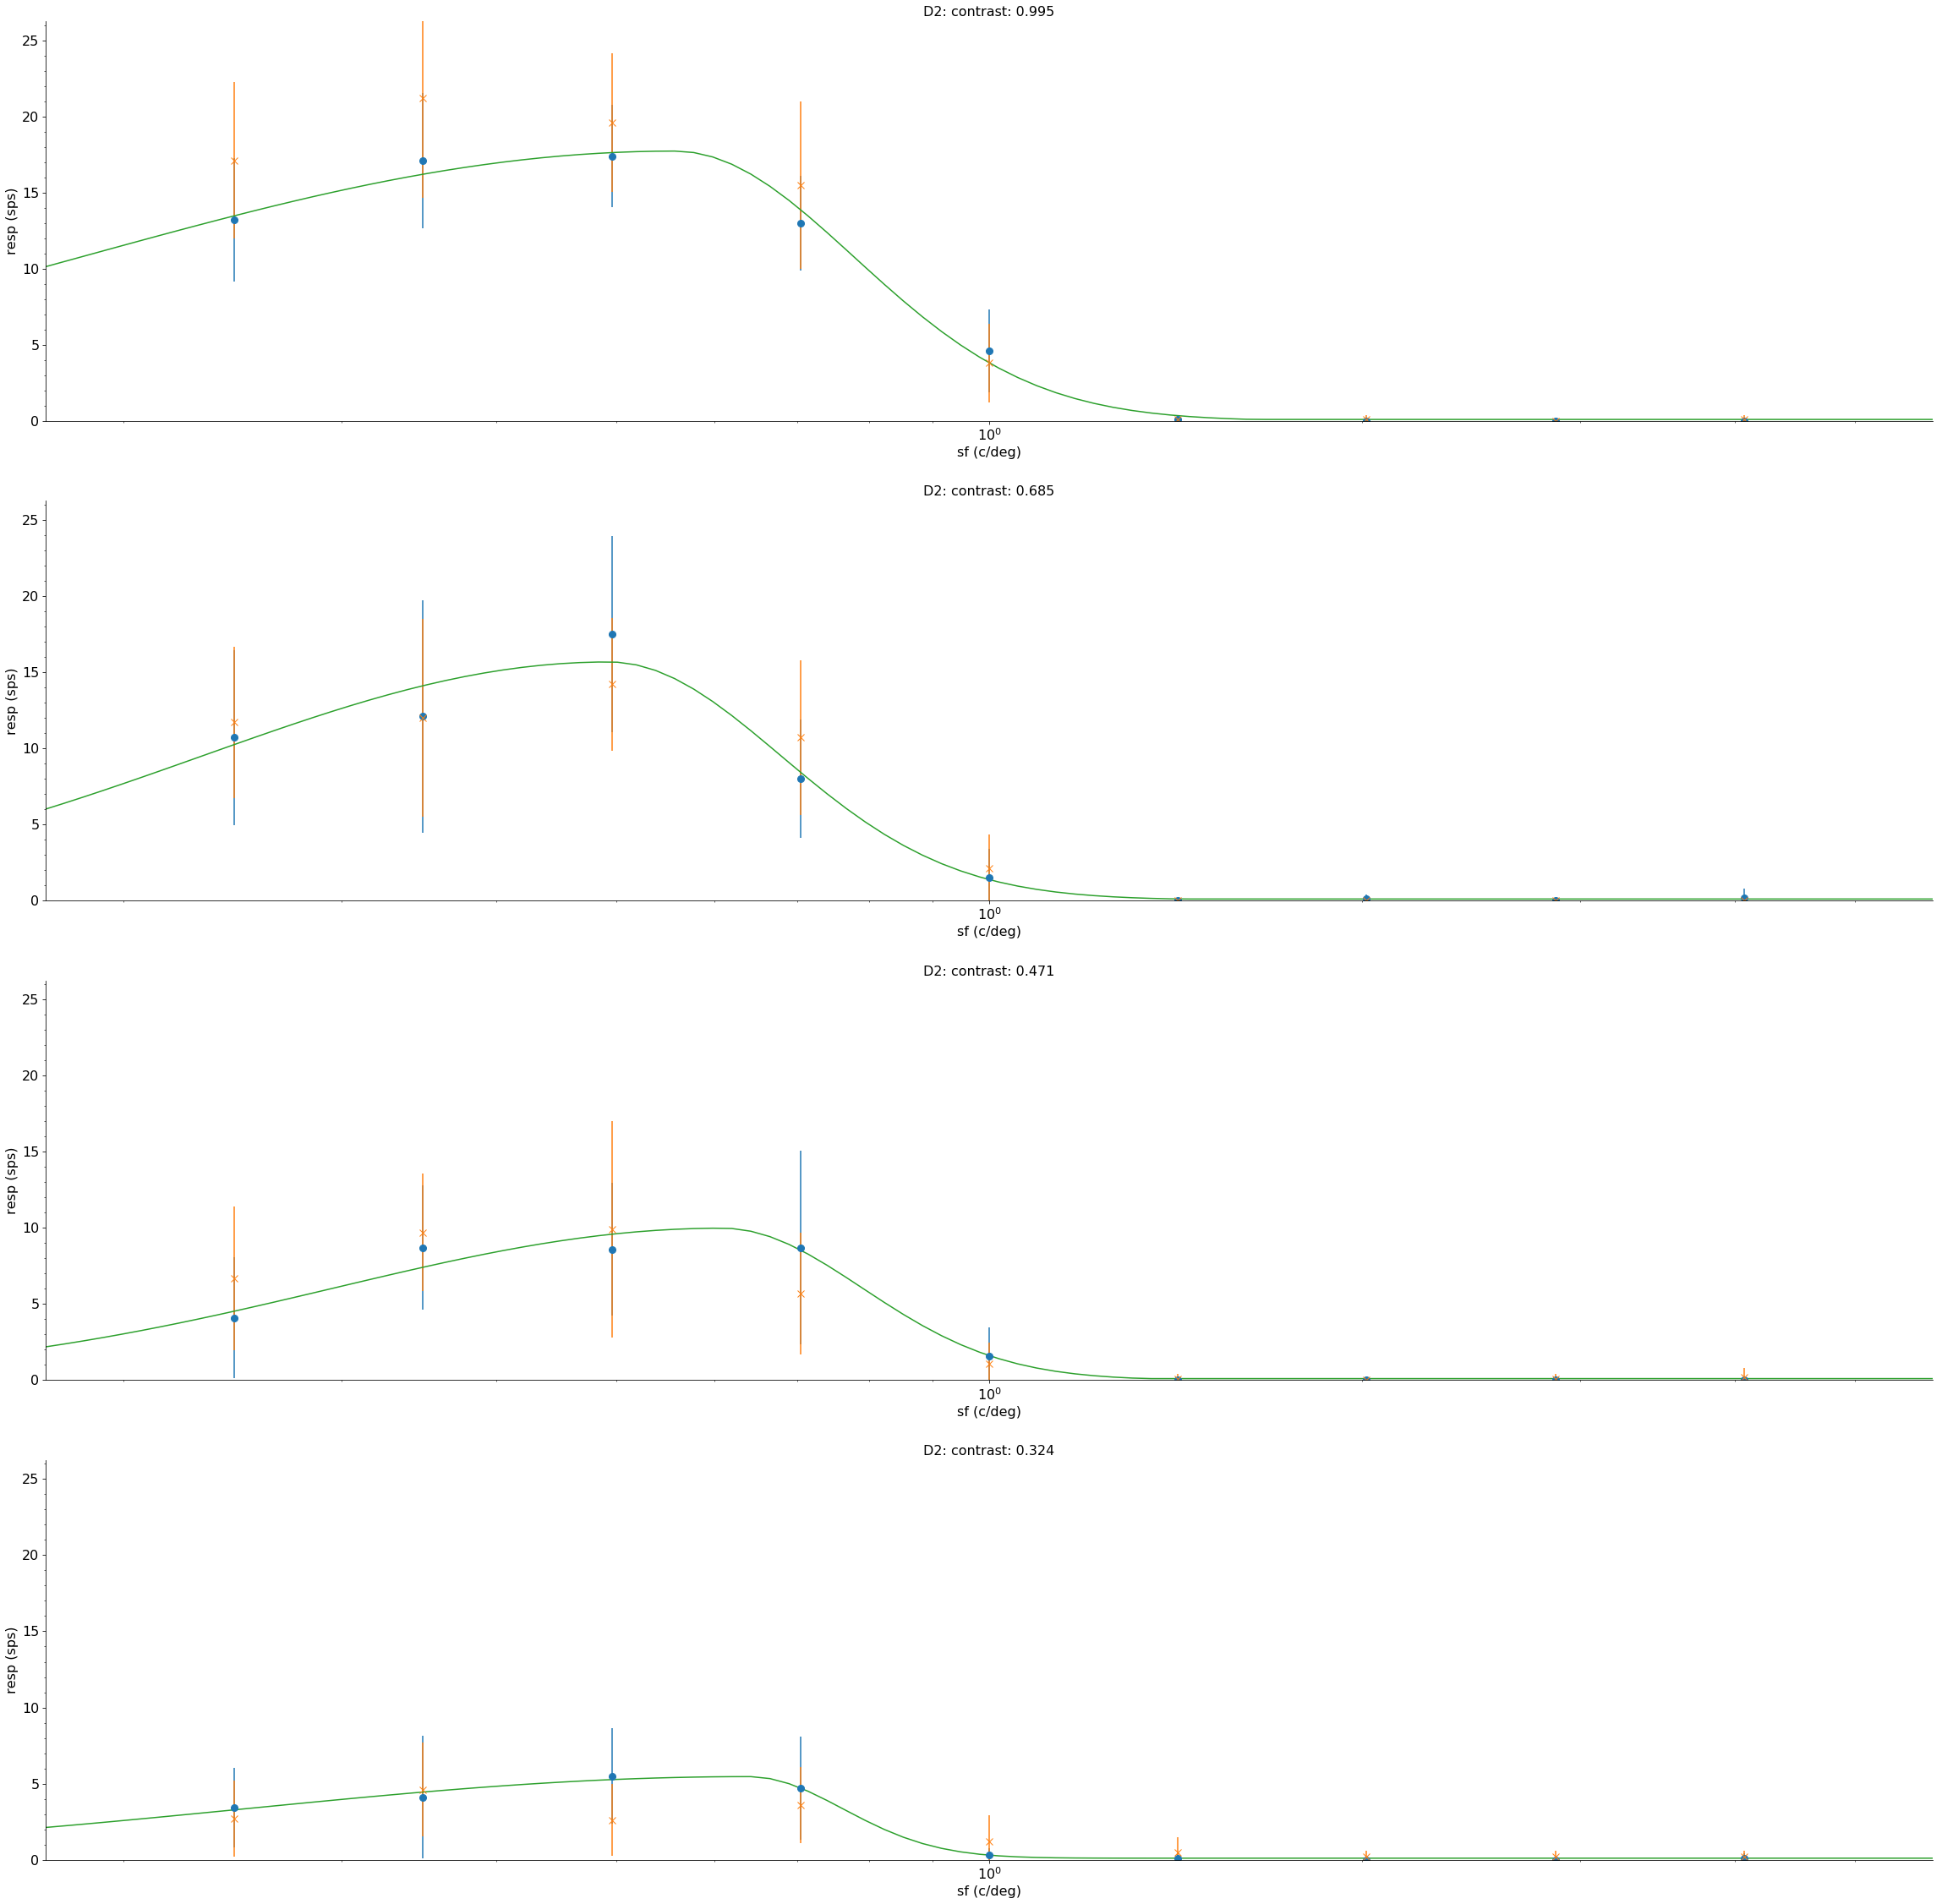

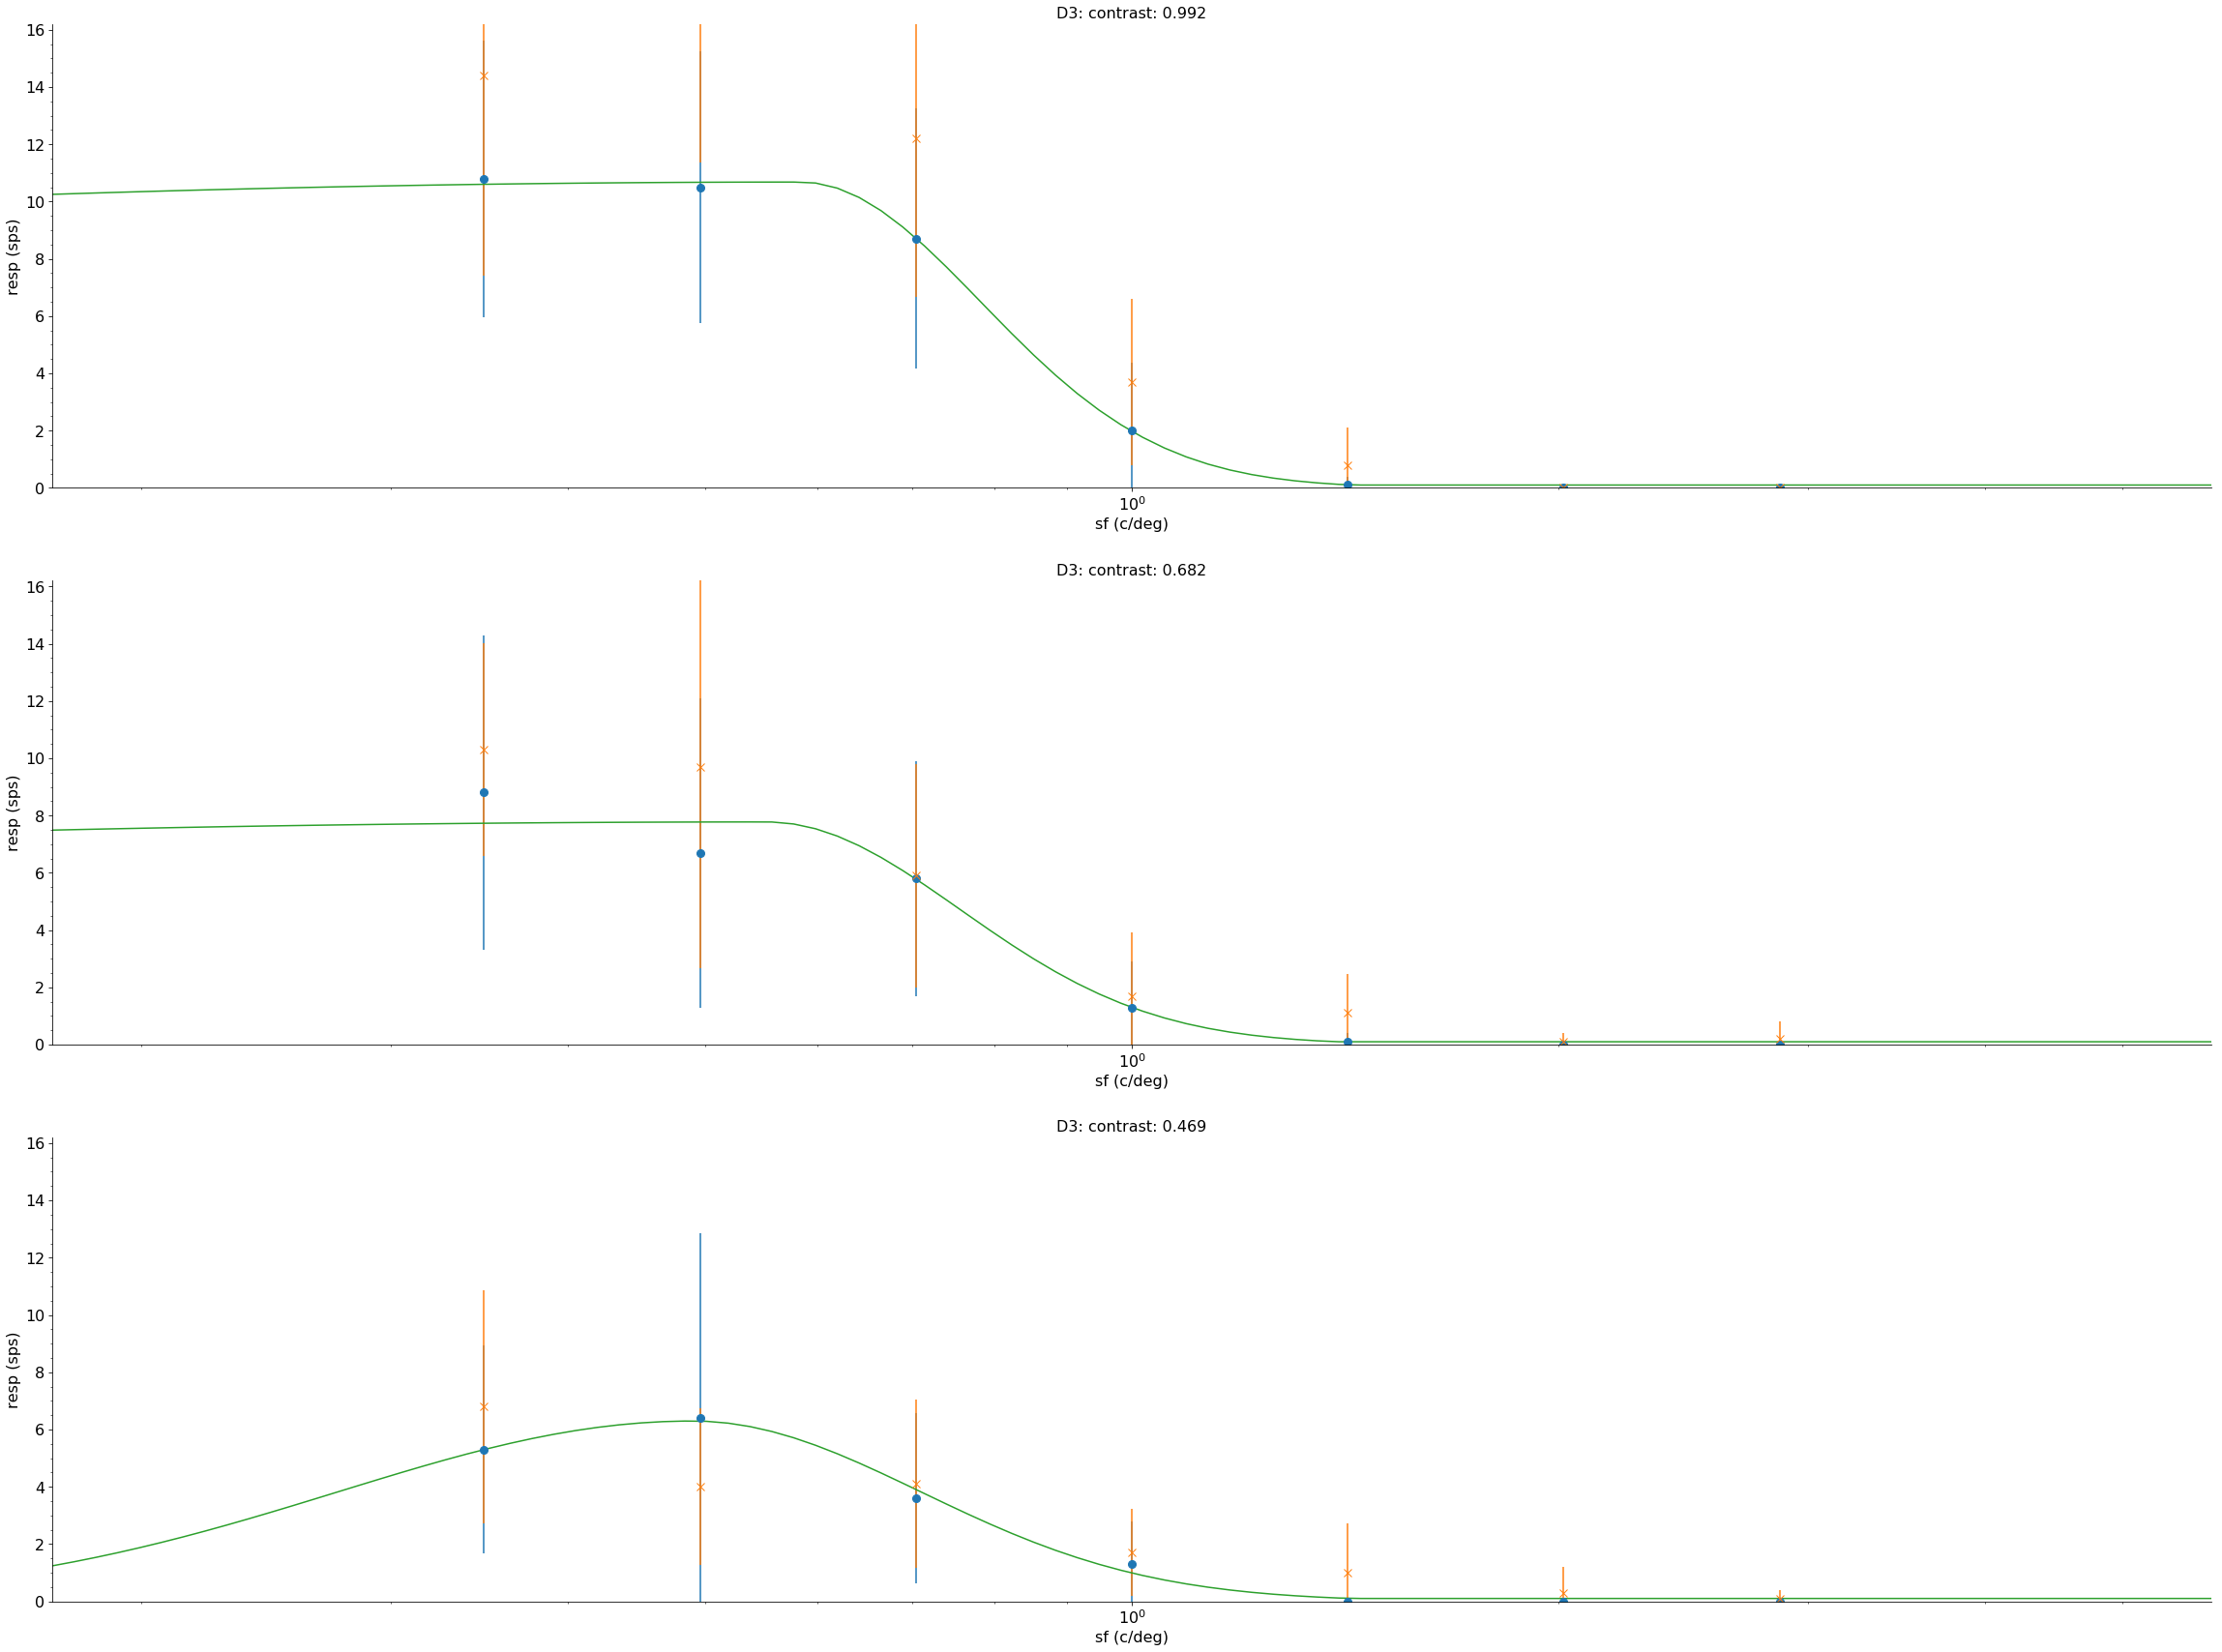

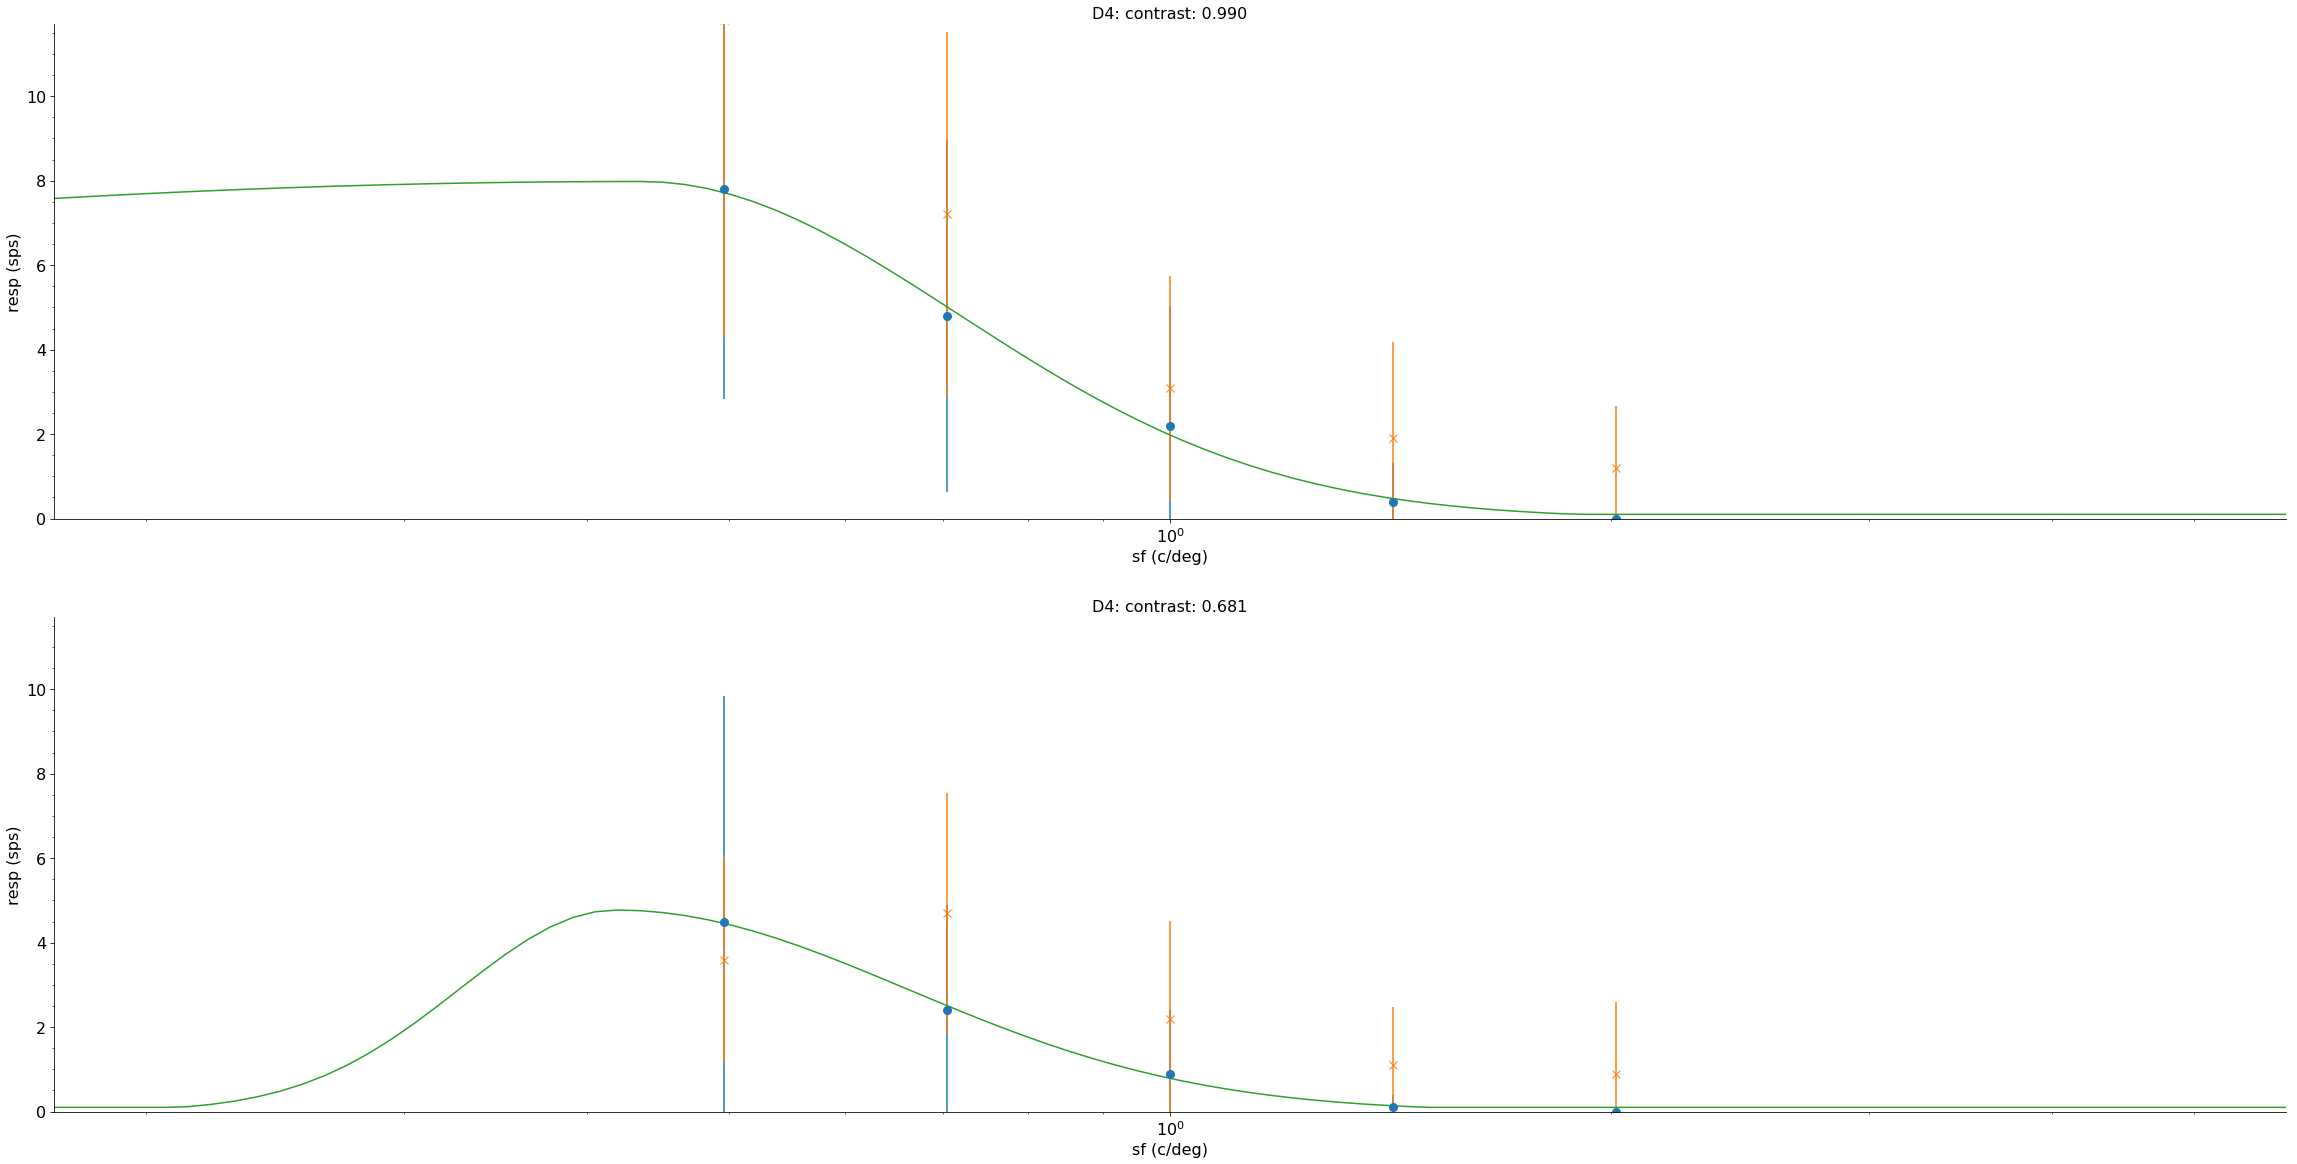

In [83]:
fDisp = []; dispAx = [];

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);    

for d in range(nDisps):
    
    v_cons = val_con_by_disp[d];
    n_v_cons = len(v_cons);
    
    fCurr, dispCurr = plt.subplots(n_v_cons, 1, figsize=(40, n_v_cons*10));
    fDisp.append(fCurr)
    dispAx.append(dispCurr);
    
    maxResp = np.max(np.max(respMean[d, ~np.isnan(respMean[d, :, :])]));
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = len(v_cons) - c - 1;
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                      respStd[d, v_sfs, v_cons[c]], fmt='o');
        # plot linear prediction
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
        curr_mod_params = descrFits[d, v_cons[c], :];
        dispAx[d][c_plt_ind].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))
        
        dispAx[d][c_plt_ind].set_xlim((min(all_sfs), max(all_sfs)));
        dispAx[d][c_plt_ind].set_ylim((0, 1.5*maxResp));
        
        dispAx[d][c_plt_ind].set_xscale('log');
#         dispAx[d][c].set_yscale('log');
        dispAx[d][c_plt_ind].set_xlabel('sf (c/deg)'); 
        dispAx[d][c_plt_ind].set_ylabel('resp (sps)');
        dispAx[d][c_plt_ind].set_title('D%d: contrast: %.3f' % (d+1, all_cons[v_cons[c]]));


saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'byDisp/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fDisp:
    pdfSv.savefig(f)
pdfSv.close()


#### Plot just sfMix contrasts

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


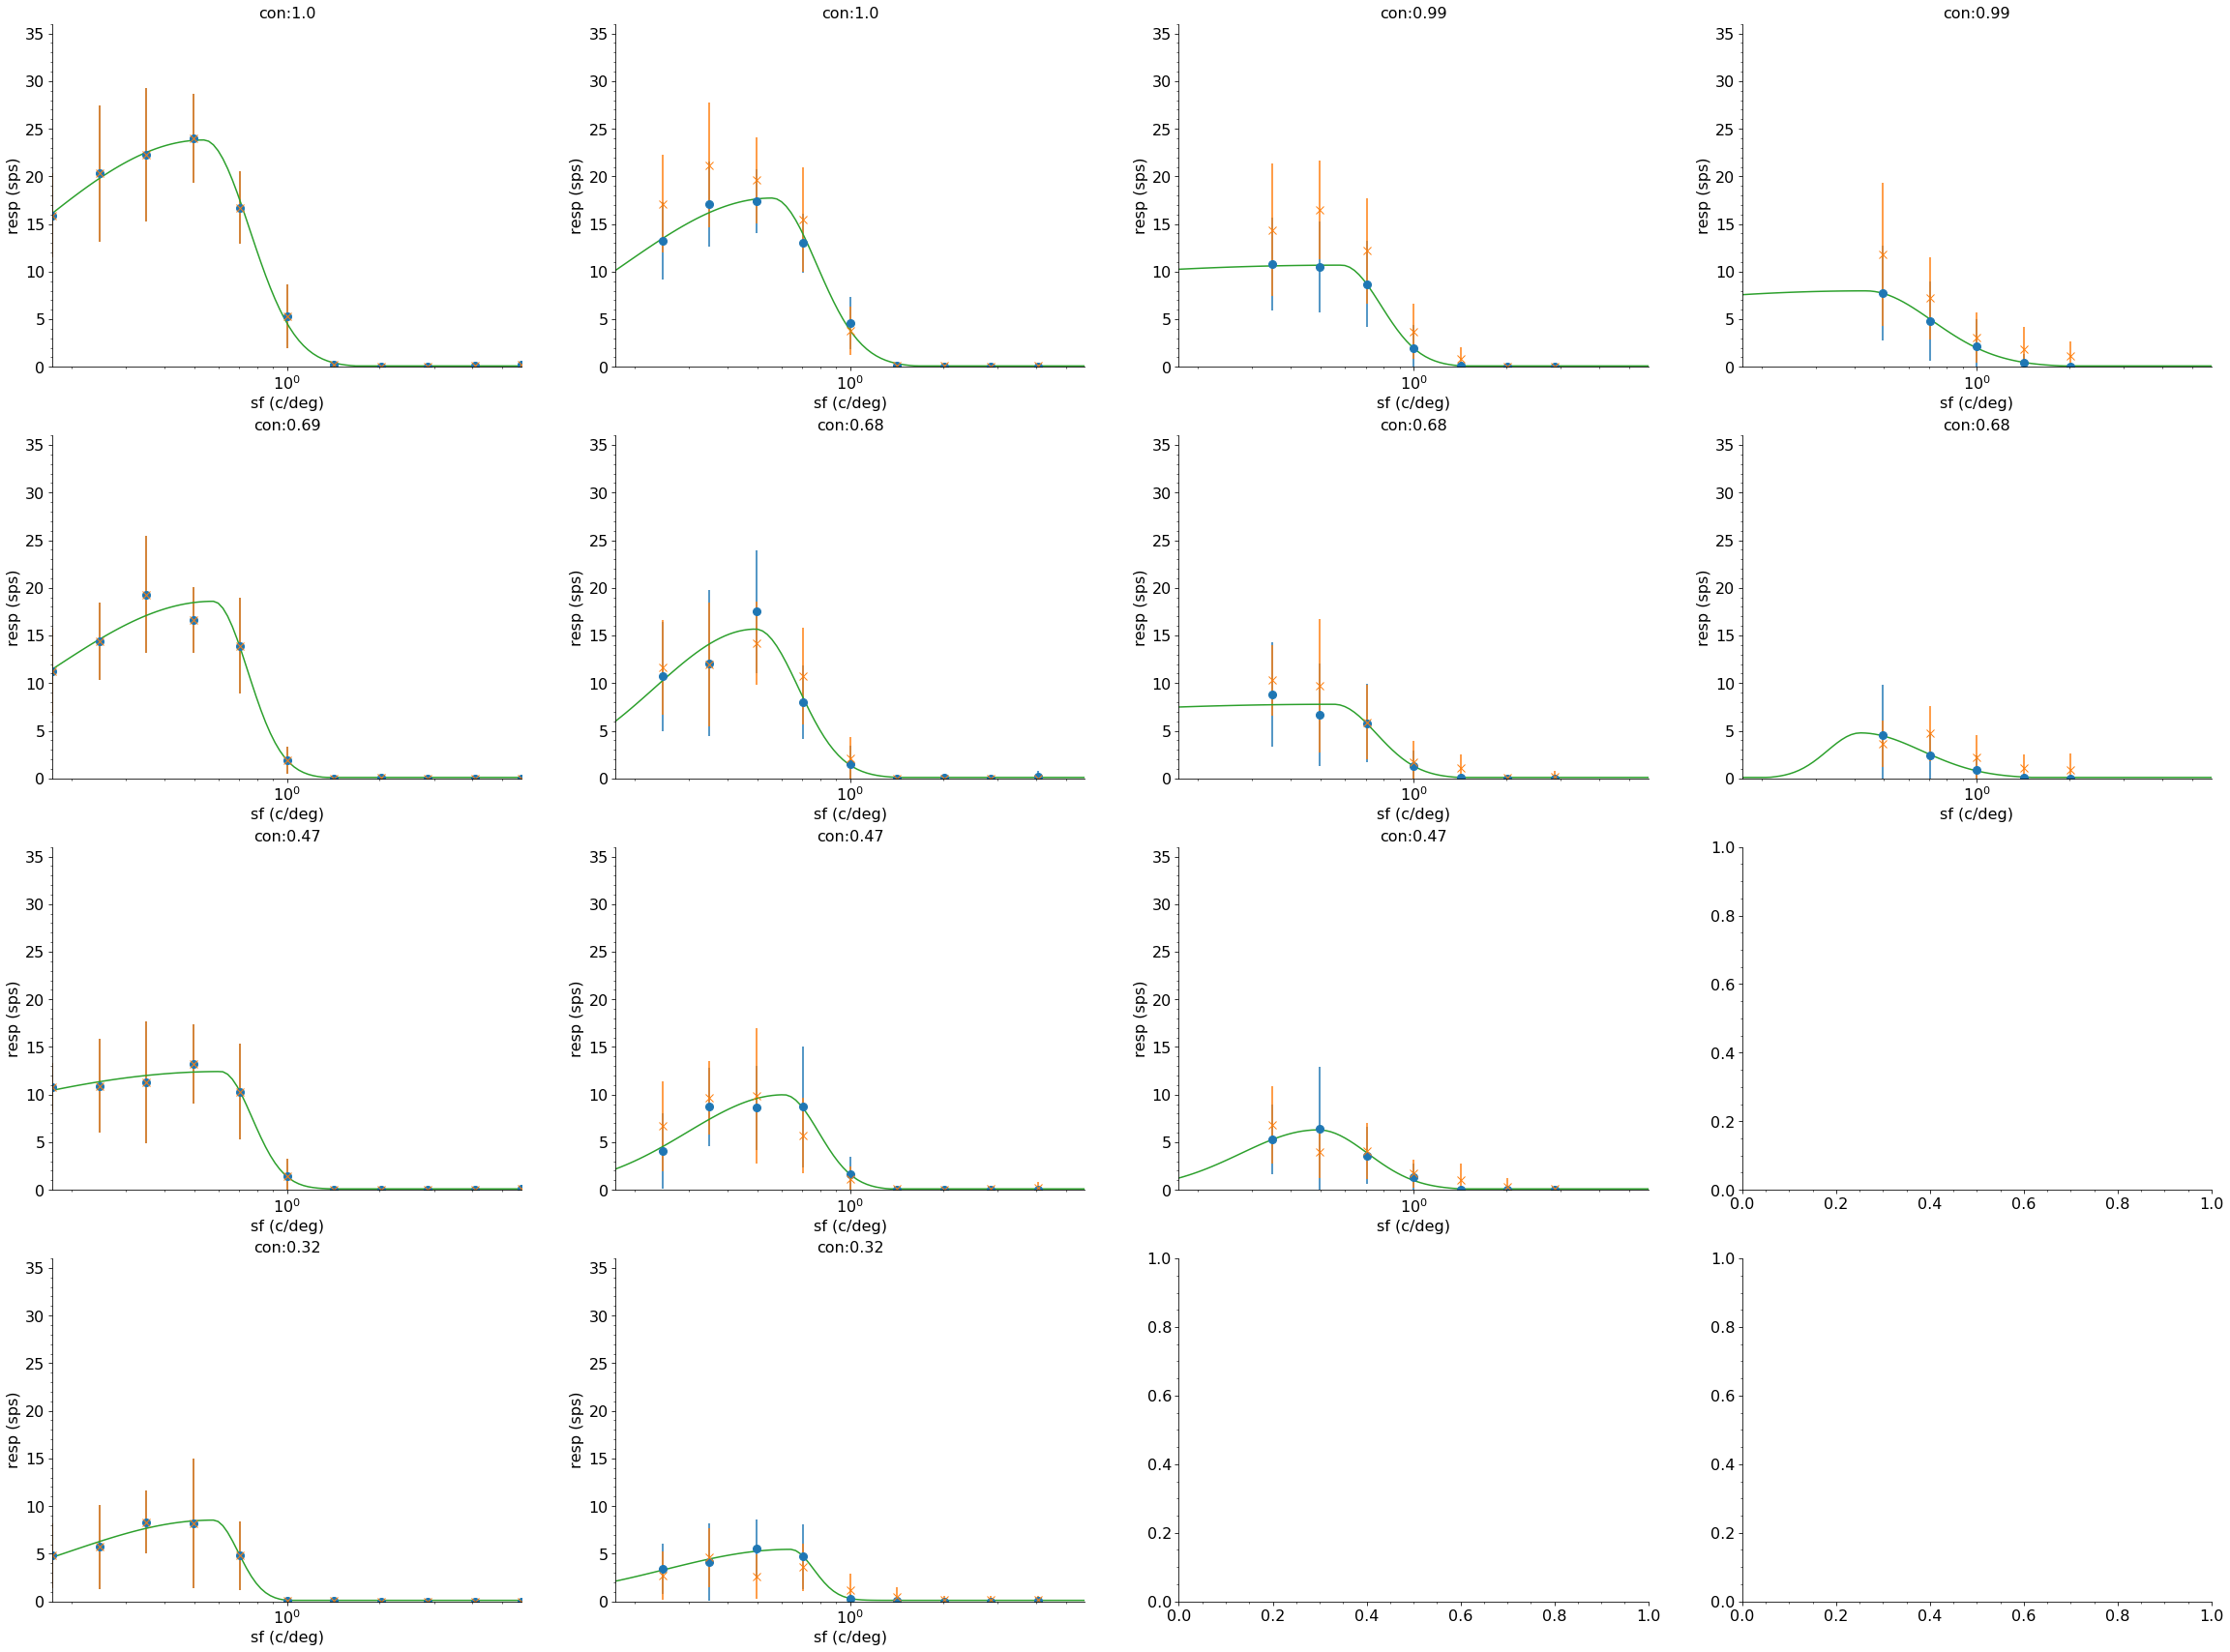

In [86]:
# i.e. highest (up to) 4 contrasts for each dispersion

mixCons = 4;
maxResp = np.max(np.max(np.max(respMean[~np.isnan(respMean)])));

f, sfMixAx = plt.subplots(mixCons, nDisps, figsize=(40, 30));

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

for d in range(nDisps):
    v_cons = np.array(val_con_by_disp[d]);
    n_v_cons = len(v_cons);
    v_cons = v_cons[np.arange(np.maximum(0, n_v_cons -mixCons), n_v_cons)]; # max(1, .) for when there are fewer contrasts than 4
    n_v_cons = len(v_cons);
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = n_v_cons - c - 1;
        sfMixAx[c_plt_ind, d].set_title('con:' + str(np.round(all_cons[v_cons[c]], 2)))
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                       respStd[d, v_sfs, v_cons[c]], fmt='o');

        # plot linear prediction
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
        curr_mod_params = descrFits[d, v_cons[c], :];
        sfMixAx[c_plt_ind, d].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))

        sfMixAx[c_plt_ind, d].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        sfMixAx[c_plt_ind, d].set_ylim((0, 1.5*maxResp));
        sfMixAx[c_plt_ind, d].set_xscale('log');
        sfMixAx[c_plt_ind, d].set_xlabel('sf (c/deg)');
        sfMixAx[c_plt_ind, d].set_ylabel('resp (sps)');
        
saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'sfMixOnly/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Plot contrast response functions

In [ ]:
crfAx = []; fCRF = [];
for d in range(nDisps):
    
    # which sfs have at least one contrast presentation?
    v_sfs = np.where(np.sum(~np.isnan(respMean[d, :, :]), axis = 1) > 0);
    n_v_sfs = len(v_sfs[0])
    fCurr, crfCurr = plt.subplots(1, n_v_sfs, figsize=(n_v_sfs*15, 20), sharex = True, sharey = True);
    fCRF.append(fCurr)
    crfAx.append(crfCurr);
    
    for sf in range(n_v_sfs):
        sf_ind = v_sfs[0][sf];
        v_cons = ~np.isnan(respMean[d, sf_ind, :]);
        n_cons = sum(v_cons);
        
        # 0.1 minimum to keep plot axis range OK...should find alternative
        crfAx[d][sf].errorbar(all_cons[v_cons], np.maximum(np.reshape([respMean[d, sf_ind, v_cons]], (n_cons, )), 0.1),
                            np.reshape([respStd[d, sf_ind, v_cons]], (n_cons, )), fmt='o');
        crfAx[d][sf].set_xscale('log');
        crfAx[d][sf].set_yscale('log');
        crfAx[d][sf].set_xlabel('contrast');
        crfAx[d][sf].set_ylabel('resp (sps)');
        crfAx[d][sf].set_title('D%d: sf: %.3f' % (d+1, all_sfs[sf_ind]));

saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'CRF/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fCRF:
    pdfSv.savefig(f)
pdfSv.close()